In [19]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import timedelta

pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',100)

In [20]:
ftse_price_df = pd.read_csv('files/1.1-FTSE_PRICES_2006-2023.csv')
ftse_price_df = ftse_price_df.iloc[:, 1:]
ftse_price_df['Month'] = ftse_price_df['Date'].astype(str).apply(lambda x: x[:8] + '01')

unique_assets_lists = ftse_price_df.Asset.unique()
unique_assets_str_lists = [str(i) for i in unique_assets_lists]

In [21]:
# preprocess columns additions and arrangements
coverage_df = v4.coverage_equ([-1])

coverage_shortlist_df = coverage_df[coverage_df.PermID.isin(unique_assets_str_lists)]
coverage_shortlist_df = coverage_shortlist_df[['PermID','Ticker','RIC']]
coverage_shortlist_df['PermID'] = coverage_shortlist_df['PermID'].astype(int)

temp_cols = coverage_shortlist_df.columns.tolist()
temp_cols2 = ftse_price_df.drop(['Asset'], axis=1).columns.tolist()
temp_cols_fin = ['Asset'] + temp_cols + temp_cols2

ftse_price_df = pd.merge(ftse_price_df, coverage_shortlist_df, how = 'left', left_on = 'Asset', right_on='PermID')
ftse_price_df = ftse_price_df[temp_cols_fin]

In [22]:
# The calculation based on: A Volatility Estimator of Stock Market Indices Based on the Intrinsic Entropy Model.
# https://arxiv.org/pdf/2205.01370.pdf

def normalised_open(df):
    """
    Normalised opening price
    """
    
    return np.log(df['Open'] / df['Close_t-1'])

def normalised_up(df):
    """
    Normalised high of the current period
    """
    
    return np.log(df['High'] / df['Open'])

def normalised_down(df):
    """
    Normalised low of the current period
    """
    
    return np.log(df['Low'] / df['Open'])

def normalised_close(df):
    """
    Normalised close of the current period
    """
    
    return np.log(df['Close'] / df['Open'])

In [23]:
def func_Vol_YangZhang(df, rolling = 30, blank_days = 30, assets = 'Asset'):
    
    cols = ['Month', 'Date', 'Asset', 'Currency']    
    k = 0.34 / (1.34 + (rolling + 1) / (rolling - 1))
    
    unique_assets_list = df[assets].unique()
    volatility_df = pd.DataFrame()

    df.loc[:, 'Date'] = pd.to_datetime(df['Date'])
    
    for asset in unique_assets_list:

        
        slice_df = df[df[assets] == asset].copy()

        # define the group based on jump on record
        slice_df.loc[:,'Jump'] = slice_df['Date'].diff() > timedelta(days=blank_days)
        slice_df.loc[:,'Group'] = slice_df['Jump'].cumsum()

        # Ordinary Volatility
        slice_df.loc[:,'Return'] = slice_df.groupby('Group')['Close'].pct_change()
        
        ### === Properties of RS === ###
        slice_df['Close_t-1'] = slice_df.groupby('Group')['Close'].shift(1)

        if len(slice_df.Group.unique()) > 1:

            slice_df['O_i'] = slice_df.groupby('Group').apply(normalised_open).droplevel('Group')
            slice_df['u_i'] = slice_df.groupby('Group').apply(normalised_up).droplevel('Group')
            slice_df['d_i'] = slice_df.groupby('Group').apply(normalised_down).droplevel('Group')
            slice_df['c_i'] = slice_df.groupby('Group').apply(normalised_close).droplevel('Group')

        else:
            slice_df['O_i'] = slice_df.groupby('Group').apply(normalised_open).T
            slice_df['u_i'] = slice_df.groupby('Group').apply(normalised_up).T
            slice_df['d_i'] = slice_df.groupby('Group').apply(normalised_down).T
            slice_df['c_i'] = slice_df.groupby('Group').apply(normalised_close).T
            

        ### === Properties of YZ (OLD with STDev) === ### 
        slice_df['V^O'] = slice_df.groupby('Group')['O_i'].rolling(window=rolling).std().droplevel('Group')
        slice_df['V^C'] = slice_df.groupby('Group')['c_i'].rolling(window=rolling).std().droplevel('Group')
        
        ### === Royal-Satchell Calculation #1 === ###
        slice_df['temp_RS'] = (slice_df['u_i'] * (slice_df['u_i'] - slice_df['c_i'])) + (slice_df['d_i'] * (slice_df['d_i'] - slice_df['c_i']))

        ### === Close to Close Calculation === ###
        slice_df.loc[:,'V^CC'] = slice_df.groupby('Group')['Return'].rolling(window=rolling).std().droplevel('Group')

        ### === Royal-Satchell Calculation #2 === ###
        slice_df['V^RS'] = slice_df.groupby('Group')['temp_RS'].rolling(window=rolling).mean().droplevel('Group')
        slice_df['V^RS'] = np.sqrt(slice_df['V^RS'])

        ### === Yang-Zhang Calculation #1 === ###
        slice_df['V^YZ'] = np.sqrt(pow(slice_df['V^O'],2) + k*pow(slice_df['V^C'],2) + (1-k)*pow(slice_df['V^RS'],2))

        volatility_df = pd.concat([volatility_df,slice_df])

    try:
        cols_arranged = volatility_df.drop(cols, axis=1).columns.tolist()
        cols = cols + cols_arranged
    except:
        cols = volatility_df.columns
    
    return volatility_df[cols]

In [6]:
ftse_volprice_df = func_Vol_YangZhang(ftse_price_df, rolling = 5)

# Visualisation

## Shell

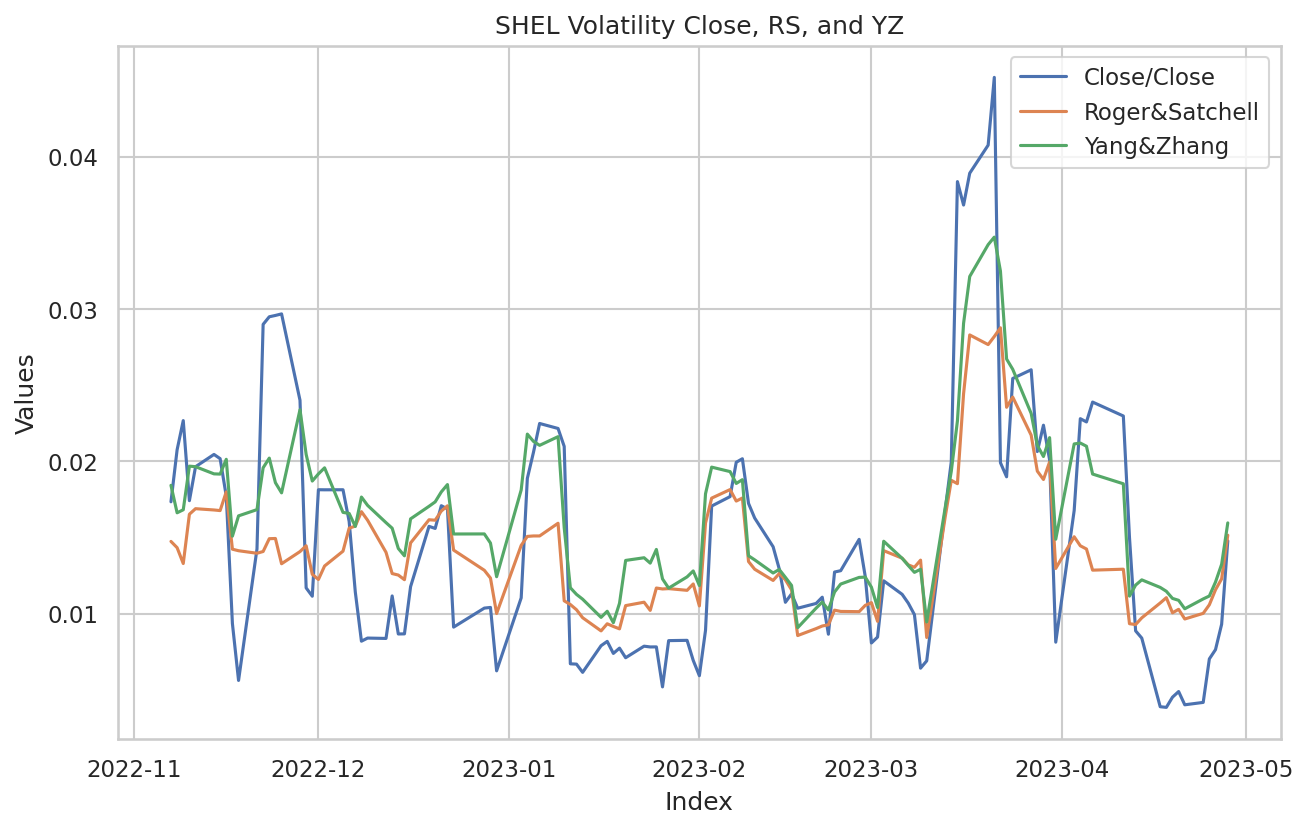

In [39]:
ticker = 'SHEL'
temp_shel_df = ftse_volprice_df[ftse_volprice_df.Ticker == ticker]
temp_shel_df = temp_shel_df[temp_shel_df['V^YZ'].notnull()].reset_index(drop=True)

temp_shel_df.Date = pd.to_datetime(temp_shel_df.Date)
temp_shel_df.index = temp_shel_df.Date

temp_shel_df = temp_shel_df[-120:]

plt.figure(figsize=(10, 6))

# Plot each column
plt.plot(temp_shel_df['V^CC'], label='Close/Close')
plt.plot(temp_shel_df['V^RS'], label='Roger&Satchell')
plt.plot(temp_shel_df['V^YZ'], label='Yang&Zhang')

# Optionally, add grid
plt.grid(True)

# Add legend to distinguish each line
plt.legend()

# Add title and labels
plt.title(f'{ticker} Volatility Close, RS, and YZ')
plt.xlabel('Index')
plt.ylabel('Values')

# Display the plot
plt.show()

## Tate

/tmp/ipykernel_468437/3586328959.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_shel_df.Date = pd.to_datetime(temp_shel_df.Date)


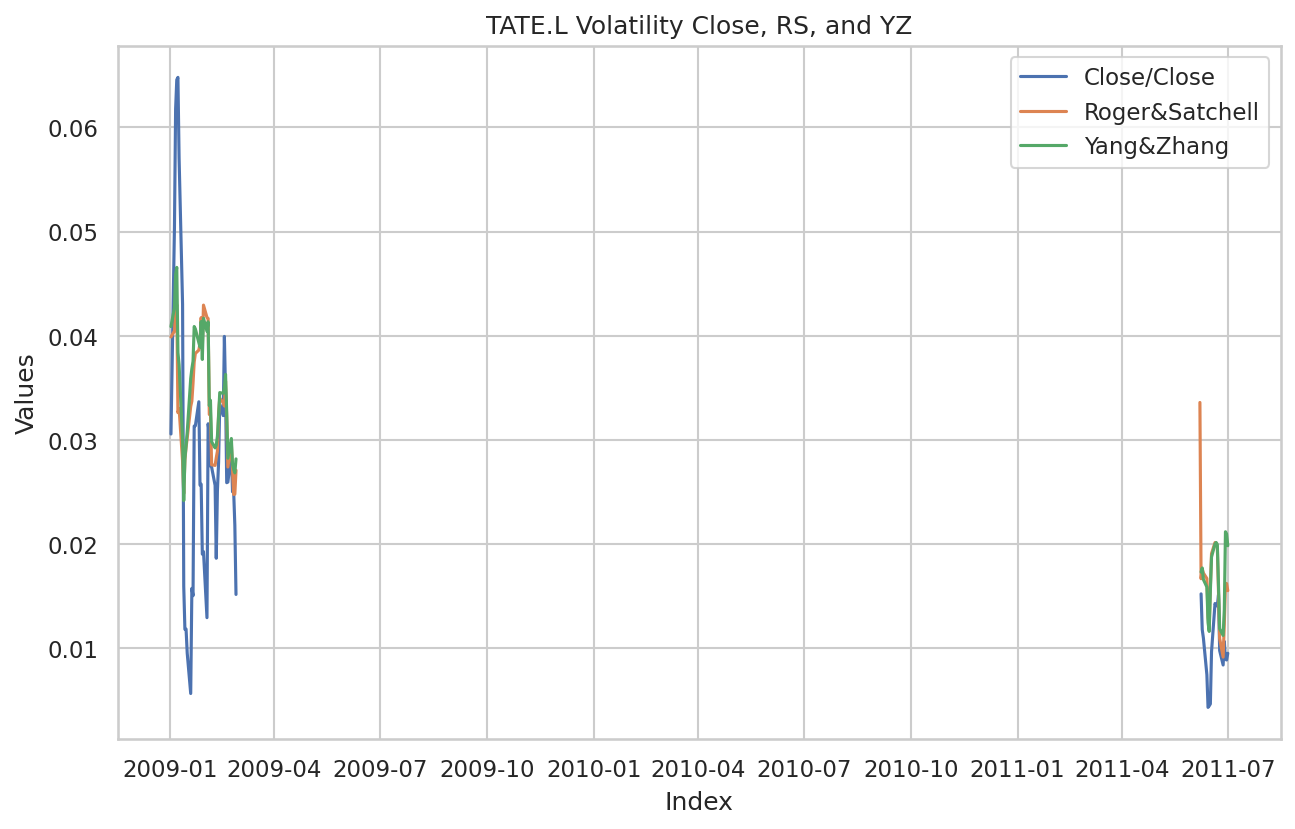

In [14]:
name = ftse_volprice_df[ftse_volprice_df['Asset'] == 4295894759].loc[440, 'RIC']

temp_shel_df = ftse_volprice_df[ftse_volprice_df['Asset'] == 4295894759]
# temp_shel_df = temp_shel_df[temp_shel_df['V^YZ'].notnull()].reset_index(drop=True)

temp_shel_df.Date = pd.to_datetime(temp_shel_df.Date)
temp_shel_df.index = temp_shel_df.Date

temp_shel_df = temp_shel_df[(temp_shel_df.index >= '2009-01-01') & (temp_shel_df.index <= '2011-07-01')]

plt.figure(figsize=(10, 6))

# Plot each column
plt.plot(temp_shel_df['V^CC'], label='Close/Close')
plt.plot(temp_shel_df['V^RS'], label='Roger&Satchell')
plt.plot(temp_shel_df['V^YZ'], label='Yang&Zhang')

# Optionally, add grid
plt.grid(True)

# Add legend to distinguish each line
plt.legend()

# Add title and labels
plt.title(f'{name} Volatility Close, RS, and YZ')
plt.xlabel('Index')
plt.ylabel('Values')

# Display the plot
plt.show()

## Astra Zeneca

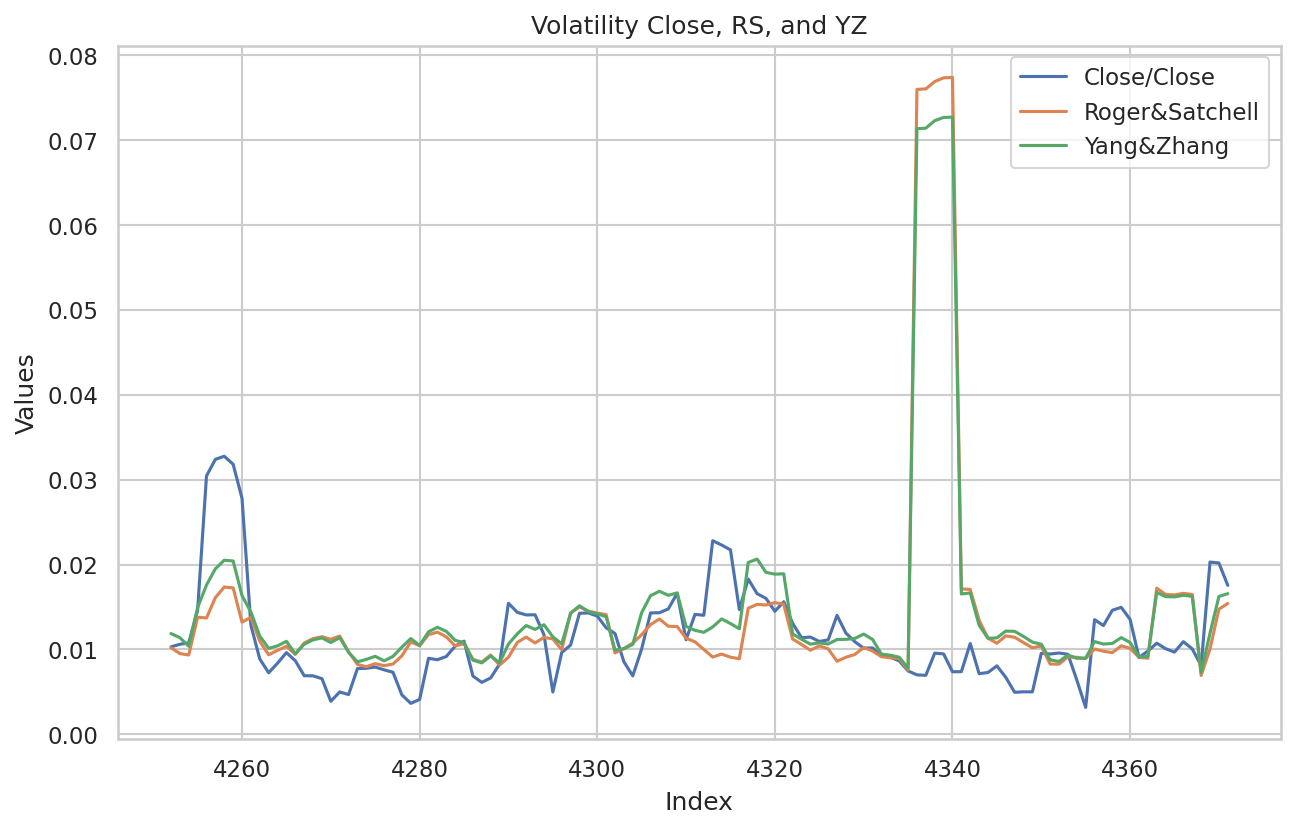

In [8]:
temp_shel_df = ftse_volprice_df[ftse_volprice_df.Ticker == 'AZN']
temp_shel_df = temp_shel_df[temp_shel_df['V^YZ'].notnull()].reset_index(drop=True)
temp_shel_df = temp_shel_df[-120:]

plt.figure(figsize=(10, 6))

# Plot each column
plt.plot(temp_shel_df['V^CC'], label='Close/Close')
plt.plot(temp_shel_df['V^RS'], label='Roger&Satchell')
plt.plot(temp_shel_df['V^YZ'], label='Yang&Zhang')

# Optionally, add grid
plt.grid(True)

# Add legend to distinguish each line
plt.legend()

# Add title and labels
plt.title('Volatility Close, RS, and YZ')
plt.xlabel('Index')
plt.ylabel('Values')

# Display the plot
plt.show()

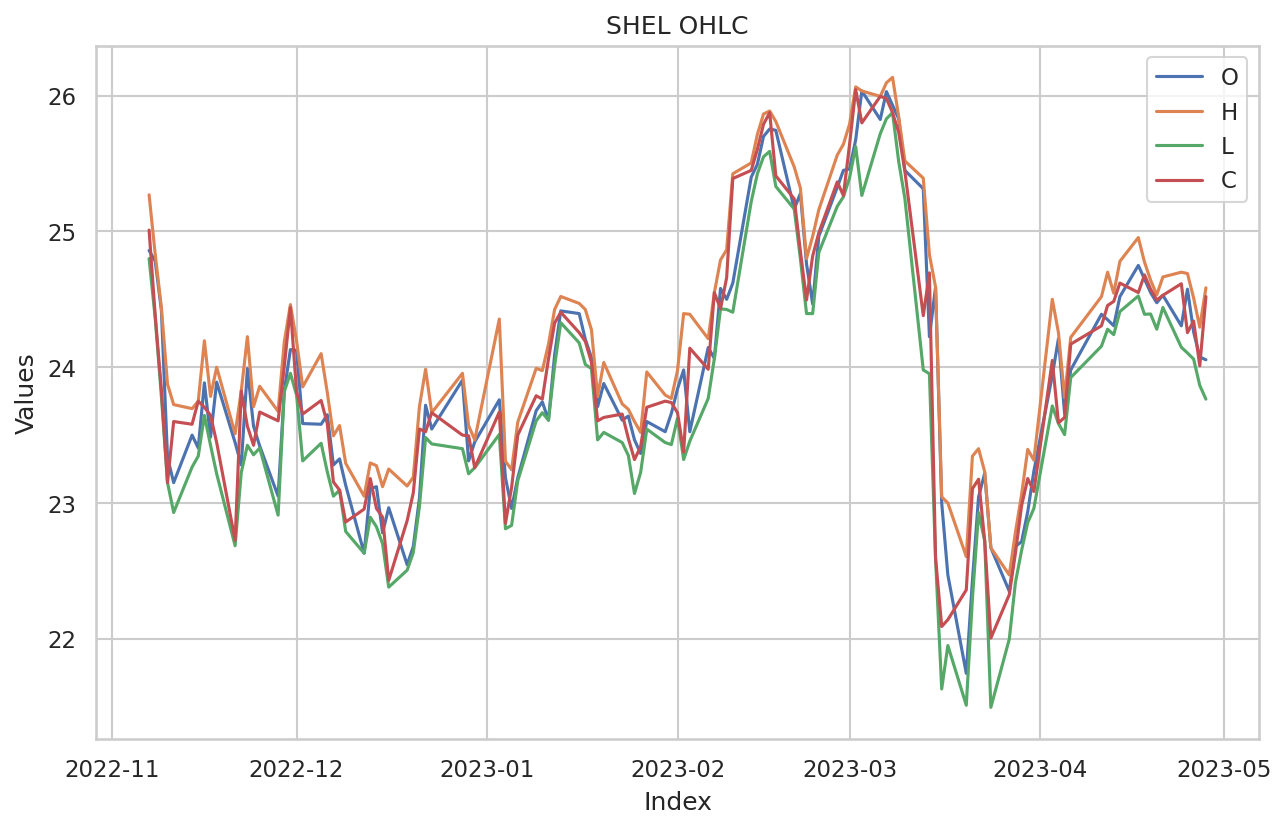

In [12]:
ticker = 'SHEL'
temp_shel_df = ftse_volprice_df[ftse_volprice_df.Ticker == ticker]
temp_shel_df = temp_shel_df[temp_shel_df['V^YZ'].notnull()].reset_index(drop=True)

temp_shel_df.Date = pd.to_datetime(temp_shel_df.Date)
temp_shel_df.index = temp_shel_df.Date

temp_shel_df = temp_shel_df[-120:]

plt.figure(figsize=(10, 6))

# Plot each column
plt.plot(temp_shel_df['Open'], label='O')
plt.plot(temp_shel_df['High'], label='H')
plt.plot(temp_shel_df['Low'], label='L')
plt.plot(temp_shel_df['Close'], label='C')

# Optionally, add grid
plt.grid(True)

# Add legend to distinguish each line
plt.legend()

# Add title and labels
plt.title(f'{ticker} OHLC')
plt.xlabel('Index')
plt.ylabel('Values')

# Display the plot
plt.show()

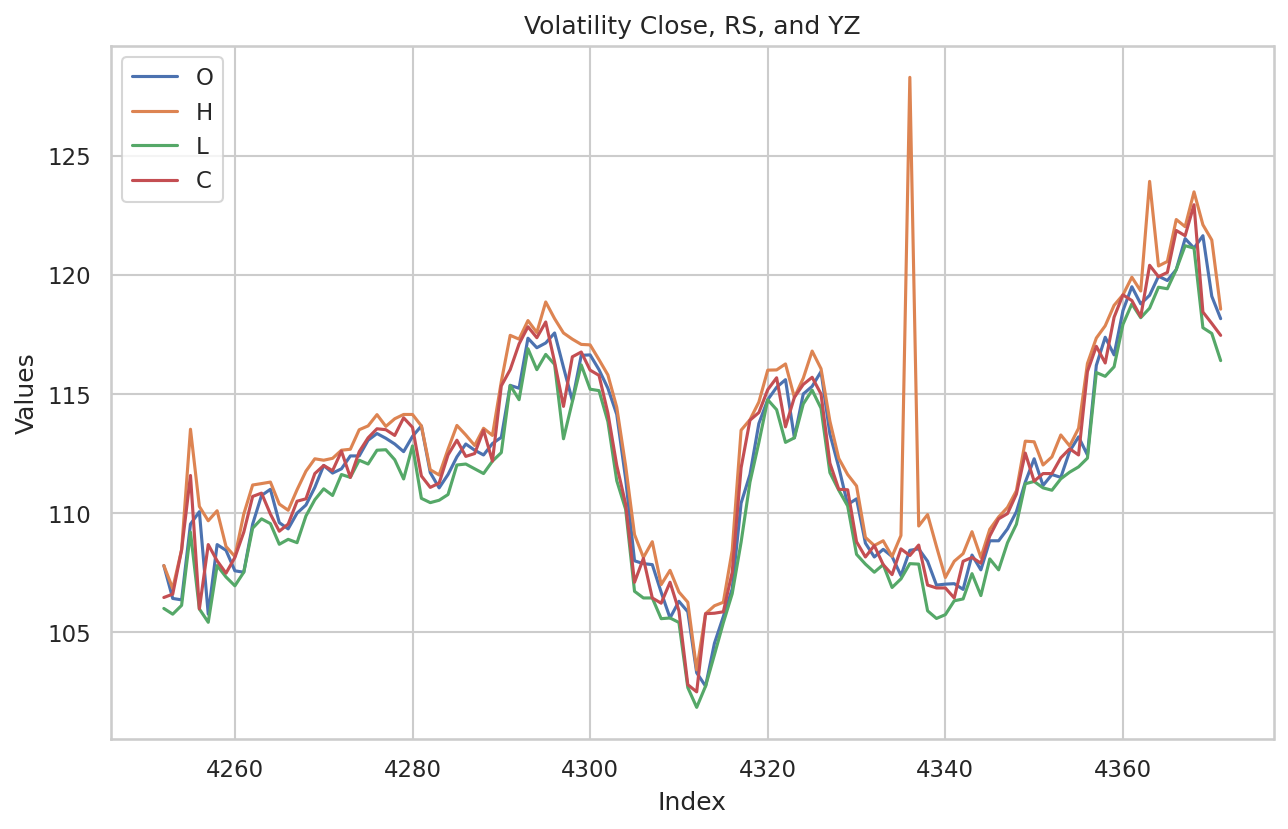

In [10]:
temp_shel_df = ftse_volprice_df[ftse_volprice_df.Ticker == 'AZN']
temp_shel_df = temp_shel_df[temp_shel_df['V^YZ'].notnull()].reset_index(drop=True)
temp_shel_df = temp_shel_df[-120:]

plt.figure(figsize=(10, 6))

# Plot each column
plt.plot(temp_shel_df['Open'], label='O')
plt.plot(temp_shel_df['High'], label='H')
plt.plot(temp_shel_df['Low'], label='L')
plt.plot(temp_shel_df['Close'], label='C')

# Optionally, add grid
plt.grid(True)

# Add legend to distinguish each line
plt.legend()

# Add title and labels
plt.title('Volatility Close, RS, and YZ')
plt.xlabel('Index')
plt.ylabel('Values')

# Display the plot
plt.show()

In [11]:
ftse_volprice_df.to_csv('files/1.1-FTSE_VOL-PRICES_2006-2023.csv', index=None)

---

# Check one

In [12]:
ftse_volprice_df.head()

,Month,Date,Asset,Currency,PermID,Ticker,RIC,Open,High,Low,Close,Volume,UnadjClose,Jump,Group,Return,Close_t-1,O_i,u_i,d_i,c_i,V^O,V^C,temp_RS,V^CC,V^RS,V^YZ
0,2006-01-01,2006-01-03 00:00:00,4295856631,AUD,4295856631,BXB,BXB.AX,9.384185,9.486490,9.365584,9.486490,2.503309e+06,10.20,False,0,NaN,NaN,NaN,0.010843,-0.001984,0.010843,NaN,NaN,0.000025,NaN,NaN,NaN
1,2006-01-01,2006-01-04 00:00:00,4295856631,AUD,4295856631,BXB,BXB.AX,9.505091,9.663199,9.505091,9.616697,2.410045e+06,10.34,False,0,0.013725,9.486490,0.001959,0.016497,0.000000,0.011673,NaN,NaN,0.000080,NaN,NaN,NaN
2,2006-01-01,2006-01-05 00:00:00,4295856631,AUD,4295856631,BXB,BXB.AX,9.700401,9.746904,9.625997,9.663199,4.212039e+06,10.39,False,0,0.004836,9.616697,0.008666,0.004782,-0.007700,-0.003842,NaN,NaN,0.000071,NaN,NaN,NaN
3,2006-01-01,2006-01-06 00:00:00,4295856631,AUD,4295856631,BXB,BXB.AX,9.598096,9.616697,9.505091,9.560894,3.953997e+06,10.28,False,0,-0.010587,9.663199,-0.006760,0.001936,-0.009737,-0.003884,NaN,NaN,0.000068,NaN,NaN,NaN
4,2006-01-01,2006-01-09 00:00:00,4295856631,AUD,4295856631,BXB,BXB.AX,9.598096,9.653899,9.598096,9.625997,3.145075e+06,10.35,False,0,0.006809,9.560894,0.003884,0.005797,0.000000,0.002903,NaN,0.007575,0.000017,NaN,0.007225,NaN


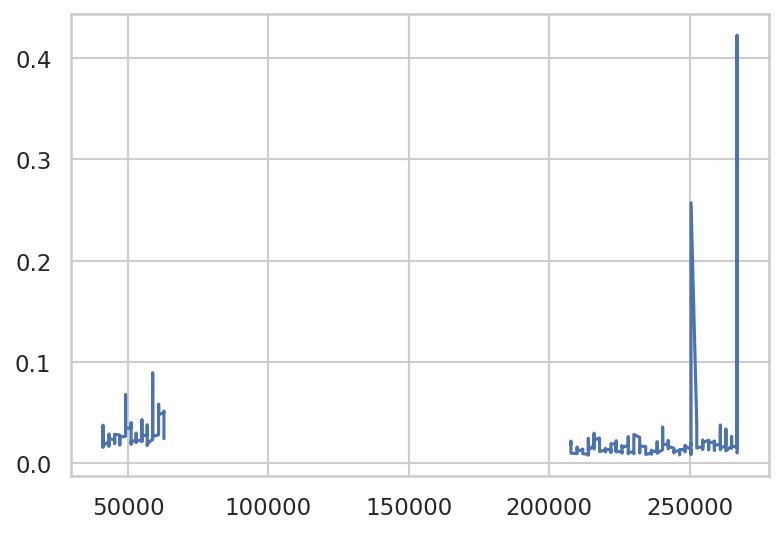

In [7]:
# this is 
plt.plot(ftse_volprice_df[ftse_volprice_df['Asset'] == 5000683618]['V^YZ'])

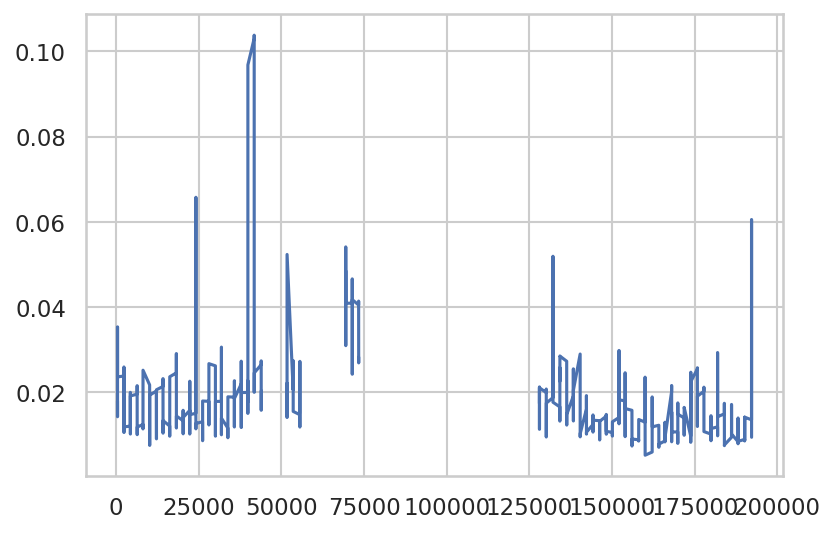

In [8]:
# this is 
plt.plot(ftse_volprice_df[ftse_volprice_df['Asset'] == 4295894759]['V^YZ'])

# Volatility Calculation for Index

## FTSE

In [31]:
indexes_df = pd.read_csv('files/1.0-indexes_price.csv')

In [32]:
FTSE_df = indexes_df[indexes_df['Name'] == '^FTSE']

In [33]:
FTSE_vol_df = func_Vol_YangZhang(FTSE_df, rolling = 5, blank_days=30, assets='Name')

In [34]:
FTSE_vol_df.to_csv('files/1.1-FTSE-IDX_VOL-PRICES_2006-2023.csv')

# Journey of Volatility using Groups

In [ ]:
test_df = ftse_price_df[ftse_price_df['Asset'] == 5000683618]
test_df.loc[:, 'Date'] = pd.to_datetime(test_df['Date'])
test_df.index = pd.to_datetime(test_df['Date'])

blank_days = 30
test_df.loc[:,'Jump'] = test_df['Date'].diff() > timedelta(days=blank_days)
test_df.loc[:,'Group'] = test_df['Jump'].cumsum()

test_df['Close_t-1'] = test_df.groupby('Group')['Close'].shift(1)



slice_df.groupby('Group').apply(normalised_open).droplevel('Group')

test_df.groupby('Group').apply(normalised_open).droplevel('Group')

rolling=30
test_df.loc[:, 'new'] = test_df.groupby('Group')['O_i'].rolling(window=rolling).std().droplevel('Group')

test_df.groupby('Group').rolling(window=rolling)['O_i']

test_df.groupby('Group')['O_i'].rolling(window=rolling).mean()

# Barclays Check Finished
<!-- https://docs.google.com/spreadsheets/d/1kur8YCg_X9QdlXLz6f0014bk4DPjY6DIxnnaG93LS7Y/edit#gid=1411703208 -->

In [26]:
temp_df = ftse_price_df[ftse_price_df['Asset'] == 8589934333]

In [32]:
temp_process_df = func_Vol_YangZhang(temp_df, rolling=5)

In [33]:
temp_process_df.head(50)

,Month,Date,Asset,Currency,PermID,Ticker,RIC,Open,High,Low,Close,Volume,UnadjClose,Jump,Group,Return,Close_t-1,O_i,u_i,d_i,c_i,V^O,V^C,temp_RS,V^CC,V^RS,V^YZ
1929,2006-01-01,2006-01-03 00:00:00,8589934333,GBP,8589934333,BARC,BARC.L,5.546110,5.586592,5.501129,5.555106,4.232327e+07,6.174998,False,0,NaN,NaN,NaN,0.007273,-0.008143,0.001621,NaN,NaN,0.000121,NaN,NaN,NaN
1930,2006-01-01,2006-01-04 00:00:00,8589934333,GBP,8589934333,BARC,BARC.L,5.604585,5.649565,5.564102,5.640569,4.149206e+07,6.269998,False,0,0.015385,5.555106,0.008867,0.007994,-0.007249,0.006400,NaN,NaN,0.000112,NaN,NaN,NaN
1931,2006-01-01,2006-01-05 00:00:00,8589934333,GBP,8589934333,BARC,BARC.L,5.640569,5.645067,5.586592,5.591090,4.242793e+07,6.214998,False,0,-0.008772,5.640569,0.000000,0.000797,-0.009615,-0.008811,NaN,NaN,0.000015,NaN,NaN,NaN
1932,2006-01-01,2006-01-06 00:00:00,8589934333,GBP,8589934333,BARC,BARC.L,5.604585,5.645067,5.595588,5.645067,3.620193e+07,6.274998,False,0,0.009654,5.591090,0.002411,0.007197,-0.001606,0.007197,NaN,NaN,0.000014,NaN,NaN,NaN
1933,2006-01-01,2006-01-09 00:00:00,8589934333,GBP,8589934333,BARC,BARC.L,5.667558,5.667558,5.555106,5.649565,6.135795e+07,6.279998,False,0,0.000797,5.645067,0.003976,0.000000,-0.020041,-0.003180,NaN,0.006728,0.000338,NaN,0.010952,NaN
1934,2006-01-01,2006-01-10 00:00:00,8589934333,GBP,8589934333,BARC,BARC.L,5.631573,5.631573,5.555106,5.568600,3.938591e+07,6.189998,False,0,-0.014331,5.649565,-0.003190,0.000000,-0.013671,-0.011245,0.004509,0.008491,0.000033,0.012363,0.010122,0.010916
1935,2006-01-01,2006-01-11 00:00:00,8589934333,GBP,8589934333,BARC,BARC.L,5.618079,5.654063,5.577596,5.636071,2.385333e+07,6.264998,False,0,0.012116,5.568600,0.008846,0.006385,-0.007232,0.003197,0.004501,0.007798,0.000096,0.011434,0.009964,0.010721
1936,2006-01-01,2006-01-12 00:00:00,8589934333,GBP,8589934333,BARC,BARC.L,5.636071,5.694546,5.618079,5.654063,2.954940e+07,6.284998,False,0,0.003192,5.636071,0.000000,0.010322,-0.003197,0.003187,0.004501,0.007222,0.000094,0.010369,0.010724,0.011302
1937,2006-01-01,2006-01-13 00:00:00,8589934333,GBP,8589934333,BARC,BARC.L,5.645067,5.663059,5.568600,5.586592,2.644891e+07,6.209998,False,0,-0.011933,5.654063,-0.001592,0.003182,-0.013638,-0.010413,0.004844,0.007023,0.000087,0.011009,0.011386,0.011978
1938,2006-01-01,2006-01-16 00:00:00,8589934333,GBP,8589934333,BARC,BARC.L,5.586592,5.591090,5.532616,5.582094,1.836258e+07,6.204998,False,0,-0.000805,5.586592,0.000000,0.000805,-0.009709,-0.000805,0.004681,0.007145,0.000088,0.010929,0.008922,0.009904
